# VI - Predictions on the test set using saved models

We can now load our best performing algorithms that we evaluated on the training
data, create our weighted voting classifier once again and train it on the entire training
data this time in order to train the model as much as possible before trying to make
predictions on unseen data.

### Setting up

In [1]:
# Default imports
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
import joblib
import os
import math

# Pre processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import f_classif, chi2
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from scipy.stats import shapiro, boxcox, pearsonr, anderson
from scipy.special import inv_boxcox
from scipy.stats import kurtosis, skew

# Sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline, make_pipeline as imb_make_pipeline

# Model evaluation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from hyperopt import hp, fmin, tpe, space_eval
from sklearn.decomposition import PCA
import shap


# Models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MeanShift, OPTICS, Birch, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import xgboost as xgboost
import lightgbm as lgboost
import catboost as catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# PyTorch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch
import torch.nn.functional as F
from hyperopt import Trials

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## A - Preparation (same as trainset)

Preparing variables

In [3]:
path = 'data/'
train_data = pd.read_csv(path + "processed_data.csv",header=0,index_col='ID')
print('Data loaded sample : ')
train_data.drop(['species'], axis=1, inplace=True)
print(train_data.shape)
train_data.head()

Data loaded sample : 
(249, 137)


,bug_type,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,mask_compactness,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_min,hue_rest_min,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bee,0.007199,65.842518,70.059270,0.046706,245.172338,55.348483,362.548639,127.671981,-0.057930,-0.817833,0.811060,172773,6818,0.046706,265227.5,0.651414,0.286969,0.826408,4.100518,0.878376,0.477971,0.099935,-0.840749,0.541425,0.502645,434.179165,1566.469267,545.078940,252.452196,7.460814,6.967513,5,1,203,255,66.750522,107.403577,54,128,47.329372,61.073311,26,43,99,156,3,2,199,255,53.387028,105.378123,36,123,44.415601,58.068684,17,49,81,151,0,0,186,255,38.786193,84.573068,23,85,35.298702,57.198890,13,28,54,132,0,0,178,179,22.955340,42.776885,14,27,35.494402,46.076375,10,21,20,38,0,0,255,255,113.963825,66.078872,115.0,51,41.474470,50.351267,83,26,143,102,5,3,203,255,66.826408,109.176003,55,128,47.295039,59.737595,26,50,99,156,0.802350,0.596853,-0.025349,-0.008629,-0.013720,0.006373,-0.001826,-0.004257,-0.010642,0.004364,-0.001702,0.008064,-0.001693,0.002286,-0.003509,0.004708,-0.000954,0.001356,-0.002313,0.000987,0.679289
2,Bee,0.008306,68.896841,40.143673,0.048440,279.998031,85.163883,478.802953,108.009513,-0.063210,-0.616582,0.652482,199332,7191,0.048440,350945.5,0.567986,0.320907,0.997932,5.416759,0.568091,0.822966,0.090493,-0.965743,0.259500,0.426842,632.800093,4440.118453,1357.730195,350.976352,7.471152,6.811326,2,0,248,255,62.015547,101.106455,54,120,41.367330,61.737563,25,36,95,151,2,1,251,255,50.140876,98.708295,32,116,41.829106,58.443197,16,42,81,145,0,0,244,255,34.095609,74.862067,18,65,33.493150,56.037654,

In [4]:
test_data = pd.read_csv(path + "processed_test_data.csv",header=0,index_col=0)
test_data.index.name = 'ID'
print(test_data.shape)
test_data.head()

(97, 137)


,bug_type,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,orthogonal_lines_ratio,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,mask_compactness,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_min,hue_rest_min,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
251,Bee,0.012571,34.232035,39.912501,0.955036,0.075980,363.482391,127.254528,712.967098,202.402522,0.785066,-0.200170,0.874382,301712,7064,0.075980,527273.5,0.572212,0.433238,0.708618,139.498230,0.785567,0.618777,0.107535,-0.777238,0.629207,0.337590,722.797816,2138.324178,757.012988,347.602106,6.848424,7.451575,5,12,255,255,112.184557,94.196447,108,93,47.170932,31.210339,81,75,141,109,0,5,255,252,100.732742,111.240172,104,116,47.446011,32.862618,63,94,130,133,0,10,255,255,72.337361,55.566709,61,47,42.760350,36.834149,42,36,99,60,0,0,179,179,28.179714,44.503692,19,41,32.103720,25.785482,14,38,30,42,0,0,255,222,102.489400,140.828899,103,147,41.545353,30.497805,71,133,133,160,6,26,255,255,114.225072,115.022385,112,118,47.102017,35.004543,82,96,142,135,0.824002,0.566587,-0.074371,0.001864,-0.023904,-0.001017,-0.015288,-0.001359,-0.008841,0.002277,-0.016440,0.000427,-0.002448,-0.003144,-0.007055,0.008961,-0.011049,-0.006328,0.000692,0.000964
252,Bee,0.015660,28.474569,38.199244,0.418034,0.128352,352.877940,99.598659,521.372169,117.222774,-0.285273,-0.612493,0.834891,375834,6066,0.128352,465431.5,0.807496,0.439881,0.610884,123.540642,0.561023,0.827800,0.092629,0.500123,-0.865954,0.485416,511.281735,919.058001,217.548839,329.964953,6.653125,7.434753,22,21,245,255,147.941022,88.316226,150,82,46.765327,31.830251,113,68,187,99,11,9,224,235,127.096875,89.628264,128,86,44.497618,26.937632,95,73,163,100,8,12,255,255,132.152299,88

In [5]:
first_test_id = test_data.index[0]
first_test_id

251

In [6]:
data = pd.concat([train_data, test_data], axis=0)
print(data.shape)
data.tail()

(346, 137)


,bug_type,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,mask_compactness,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_min,hue_rest_min,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
343,Bee,0.014897,53.429873,55.499780,0.143115,360.812943,103.069191,542.534475,169.166078,-0.067651,-1.295083,0.626923,357534,5603,0.143115,488169.0,0.732398,0.484757,0.626525,84.348442,0.531708,0.846928,0.090127,-0.122174,-0.992509,0.527274,683.351540,1032.184980,338.797889,397.941324,7.150870,7.076172,11,5,200,253,103.694600,80.624921,109,58,39.255052,56.670498,77,44,133,102,7,11,183,253,77.160150,92.562063,77,77,33.739929,52.859344,53,56,100,116,4,1,201,255,57.854990,71.171534,53,50,30.150168,58.670596,37,34,73,76,0,0,179,179,25.586053,53.505002,13,48,41.834943,25.654529,11,41,16,56,0,0,240,232,112.592604,81.963523,114.0,89,43.030347,36.171983,82,66,145,105,11,11,201,255,103.908800,94.242015,109,78,39.272757,55.801183,77,56,133,117,0.824720,0.565542,-0.050092,-0.001639,-0.033918,-0.003150,-0.019483,-0.003123,-0.010906,-0.000049,-0.007465,-0.000605,-0.005467,0.001720,-0.007223,0.000152,-0.007227,-0.001008,-0.006672,-0.000802,0.418113
344,Bee,0.017551,36.261817,62.981213,0.099547,365.340178,96.302185,565.040855,162.860782,-0.019667,-0.958593,0.950617,421222,7292,0.099547,576862.0,0.730195,0.398510,0.821891,129.045822,0.775548,0.631289,0.098368,0.249396,-0.968402,0.469000,512.809948,2074.795159,609.538813,331.951354,7.154222,7.313481,7,6,229,238,104.661342,74.958347,109,51,42.209718,55.220538,73,38,135,104,3,10,212,232,81.730434,83.641084,77,65,41.810742,52.845095,48,46,111,115,0,2,225,253,60.045999,65.059856,52,42,3

In [7]:
RANDOM_STATE = 10
print(data.bug_type.value_counts())
data = data.drop(['mask_compactness'], axis=1)
for col in data.columns:
    col_sum = data[col].sum()
    if col_sum == 0:
        print('Dropped column because completely null:', col)
        data.drop(col, axis=1, inplace=True)
data.head()

bug_type
Bee          151
Bumblebee    146
Butterfly     21
Wasp          15
Hover fly     12
Dragonfly      1
Name: count, dtype: int64
Dropped column because completely null: hue_mask_min
Dropped column because completely null: hue_rest_min


,bug_type,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bee,0.007199,65.842518,70.059270,0.046706,245.172338,55.348483,362.548639,127.671981,-0.057930,-0.817833,0.811060,172773,6818,265227.5,0.651414,0.286969,0.826408,4.100518,0.878376,0.477971,0.099935,-0.840749,0.541425,0.502645,434.179165,1566.469267,545.078940,252.452196,7.460814,6.967513,5,1,203,255,66.750522,107.403577,54,128,47.329372,61.073311,26,43,99,156,3,2,199,255,53.387028,105.378123,36,123,44.415601,58.068684,17,49,81,151,0,0,186,255,38.786193,84.573068,23,85,35.298702,57.198890,13,28,54,132,178,179,22.955340,42.776885,14,27,35.494402,46.076375,10,21,20,38,0,0,255,255,113.963825,66.078872,115.0,51,41.474470,50.351267,83,26,143,102,5,3,203,255,66.826408,109.176003,55,128,47.295039,59.737595,26,50,99,156,0.802350,0.596853,-0.025349,-0.008629,-0.013720,0.006373,-0.001826,-0.004257,-0.010642,0.004364,-0.001702,0.008064,-0.001693,0.002286,-0.003509,0.004708,-0.000954,0.001356,-0.002313,0.000987,0.679289
2,Bee,0.008306,68.896841,40.143673,0.048440,279.998031,85.163883,478.802953,108.009513,-0.063210,-0.616582,0.652482,199332,7191,350945.5,0.567986,0.320907,0.997932,5.416759,0.568091,0.822966,0.090493,-0.965743,0.259500,0.426842,632.800093,4440.118453,1357.730195,350.976352,7.471152,6.811326,2,0,248,255,62.015547,101.106455,54,120,41.367330,61.737563,25,36,95,151,2,1,251,255,50.140876,98.708295,32,116,41.829106,58.443197,16,42,81,145,0,0,244,255,34.095609,74.862067,18,65,33.493150,56.037654,10,24,53,120,179,179,24.344230,40.257719,16,27,34.256773,43.175612,1

In [8]:
X = data.drop(columns=['bug_type'])
target = 'bug_type'
y = data[target]
classes = np.unique(y)
n_classes = len(classes)
X.head()

,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.007199,65.842518,70.059270,0.046706,245.172338,55.348483,362.548639,127.671981,-0.057930,-0.817833,0.811060,172773,6818,265227.5,0.651414,0.286969,0.826408,4.100518,0.878376,0.477971,0.099935,-0.840749,0.541425,0.502645,434.179165,1566.469267,545.078940,252.452196,7.460814,6.967513,5,1,203,255,66.750522,107.403577,54,128,47.329372,61.073311,26,43,99,156,3,2,199,255,53.387028,105.378123,36,123,44.415601,58.068684,17,49,81,151,0,0,186,255,38.786193,84.573068,23,85,35.298702,57.198890,13,28,54,132,178,179,22.955340,42.776885,14,27,35.494402,46.076375,10,21,20,38,0,0,255,255,113.963825,66.078872,115.0,51,41.474470,50.351267,83,26,143,102,5,3,203,255,66.826408,109.176003,55,128,47.295039,59.737595,26,50,99,156,0.802350,0.596853,-0.025349,-0.008629,-0.013720,0.006373,-0.001826,-0.004257,-0.010642,0.004364,-0.001702,0.008064,-0.001693,0.002286,-0.003509,0.004708,-0.000954,0.001356,-0.002313,0.000987,0.679289
2,0.008306,68.896841,40.143673,0.048440,279.998031,85.163883,478.802953,108.009513,-0.063210,-0.616582,0.652482,199332,7191,350945.5,0.567986,0.320907,0.997932,5.416759,0.568091,0.822966,0.090493,-0.965743,0.259500,0.426842,632.800093,4440.118453,1357.730195,350.976352,7.471152,6.811326,2,0,248,255,62.015547,101.106455,54,120,41.367330,61.737563,25,36,95,151,2,1,251,255,50.140876,98.708295,32,116,41.829106,58.443197,16,42,81,145,0,0,244,255,34.095609,74.862067,18,65,33.493150,56.037654,10,24,53,120,179,179,24.344230,40.257719,16,27,34.256773,43.175612,11,22,23,36,0,0,255

In [9]:
labelencoder = LabelEncoder()
y5 = y.copy()
y5[~y5.isin(['Bee', 'Bumblebee','Wasp','Butterfly'])] = 'Other'
y_encoded5 = labelencoder.fit_transform(y5)
y5.value_counts()

bug_type
Bee          151
Bumblebee    146
Butterfly     21
Wasp          15
Other         13
Name: count, dtype: int64

In [10]:
# Preparing the folds for training with 4 splits
cv = StratifiedKFold(n_splits=4, random_state=2, shuffle=True)

def check_splits(X, y, cv, min_samples_per_class_in_train=3, min_samples_per_class_in_test=2):
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Ensure we have at least 2 instances of each class in each set
        for class_name in np.unique(y):
            if class_name == 'Dragonfly':
                continue
            if len(y_train[y_train == class_name]) < min_samples_per_class_in_train:
                print(f"Train set has less than {min_samples_per_class_in_train} instances of class", class_name)
            if len(y_test[y_test == class_name]) < min_samples_per_class_in_test:
                print(f"Test set has less than {min_samples_per_class_in_test} instances of class", class_name)
check_splits(X, y, cv)

In [11]:
# Defining the list for feature categories

columns = X.columns
def get_remaining_features(columns, group_to_substract):
    remaining_features = [col for col in columns if col not in group_to_substract]
    print(f"Remaining features : {remaining_features}")
    return remaining_features
# Defining the color features
rgb_colors = ['red', 'green', 'blue']
hsv_colors = ['hue', 'saturation', 'value']
parts = ['mask', 'rest']
stats = ['min', 'q1','mean', 'q3', 'max','std','median']
rgb_features = [f'{color}_{part}_{stat}' for color in rgb_colors for part in parts for stat in stats]
hsv_features = [f'{color}_{part}_{stat}' for color in hsv_colors for part in parts for stat in stats]
color_features = rgb_features + hsv_features
remaining_features = get_remaining_features(columns, color_features)
# Defining the fourier descriptor features
suffix = ['real', 'imag']
fourier_features = [f'fourier_descriptor_{s}_{i}' for i in range(0, 10) for s in suffix]
remaining_features = get_remaining_features(remaining_features, fourier_features)

stats = ['min', 'mean', 'max','std','skewness', 'kurtosis']
centroid_distance_features = [f'{stat}_centroid_distance' for stat in stats]

remaining_features = get_remaining_features(remaining_features, centroid_distance_features)
# Defining the shape / geometry features
geometry_features = ["nb_pixels_ratio", "image_symmetry_index", "mask_bb_symmetry_index", "roundness", "aspect_ratio", "mask_area",
                 "mask_perimeter", "hull_area", "hull_to_insect_area_ratio", "hull_convexity", "hull_triangle_similarity", 
                 "ellipse_angle", "ellipse_axis_ratio", "ellipse_eccentricity", "ellipse_variance", "axis_least_inertia_x", "axis_least_inertia_y",
                   "rectangularity", "orthogonal_lines_ratio"]
remaining_features = get_remaining_features(remaining_features, geometry_features)

# Dividing shape_features into subgroups 
# overall dimension / scale of the insect
size_features = ['nb_pixels_ratio', 'mask_area', 'hull_area', 'mask_perimeter']
# derived from fitting an ellipse to the insect
elliptical_shape_features = ['ellipse_angle', 'ellipse_axis_ratio', 'ellipse_eccentricity', 'ellipse_variance']
inertia_features = ['axis_least_inertia_x', 'axis_least_inertia_y']
shape_features = ['roundness', 'aspect_ratio', 'rectangularity', 'orthogonal_lines_ratio', 'hull_convexity', 'hull_to_insect_area_ratio', 'hull_triangle_similarity']

stat = ['mean_length','max_length', 'std_length', 'spread']
body_parts_features = [f'body_parts_{s}' for s in stat]

remaining_features = get_remaining_features(remaining_features, body_parts_features)
texture_features = ['mask_entropy','rest_entropy']

Remaining features : ['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index', 'roundness', 'mean_centroid_distance', 'std_centroid_distance', 'max_centroid_distance', 'min_centroid_distance', 'skewness_centroid_distance', 'kurtosis_centroid_distance', 'aspect_ratio', 'mask_area', 'mask_perimeter', 'hull_area', 'hull_to_insect_area_ratio', 'hull_convexity', 'hull_triangle_similarity', 'ellipse_angle', 'ellipse_axis_ratio', 'ellipse_eccentricity', 'ellipse_variance', 'axis_least_inertia_x', 'axis_least_inertia_y', 'rectangularity', 'body_parts_mean_length', 'body_parts_max_length', 'body_parts_std_length', 'body_parts_spread', 'rest_entropy', 'mask_entropy', 'fourier_descriptor_real_0', 'fourier_descriptor_imag_0', 'fourier_descriptor_real_1', 'fourier_descriptor_imag_1', 'fourier_descriptor_real_2', 'fourier_descriptor_imag_2', 'fourier_descriptor_real_3', 'fourier_descriptor_imag_3', 'fourier_descriptor_real_4', 'fourier_descriptor_imag_4', 'fourier_descriptor_real_5', 'fo

In [12]:
# Displaying the features by group

print('RGB color features:', rgb_features)
print('HSV color features:', hsv_features)
print('Fourier descriptor features:', fourier_features)
print('Centroid distance features:', centroid_distance_features)
print('Texture features: ', texture_features)
print('Geometry features:', geometry_features)
print('')
print('Geometry features is divided in the following subgroups :')
print('• Shape features:', shape_features)
print('• Size features:', size_features)
print('• Elliptical shape features:', elliptical_shape_features)
print('• Inertia features:', inertia_features)

RGB color features: ['red_mask_min', 'red_mask_q1', 'red_mask_mean', 'red_mask_q3', 'red_mask_max', 'red_mask_std', 'red_mask_median', 'red_rest_min', 'red_rest_q1', 'red_rest_mean', 'red_rest_q3', 'red_rest_max', 'red_rest_std', 'red_rest_median', 'green_mask_min', 'green_mask_q1', 'green_mask_mean', 'green_mask_q3', 'green_mask_max', 'green_mask_std', 'green_mask_median', 'green_rest_min', 'green_rest_q1', 'green_rest_mean', 'green_rest_q3', 'green_rest_max', 'green_rest_std', 'green_rest_median', 'blue_mask_min', 'blue_mask_q1', 'blue_mask_mean', 'blue_mask_q3', 'blue_mask_max', 'blue_mask_std', 'blue_mask_median', 'blue_rest_min', 'blue_rest_q1', 'blue_rest_mean', 'blue_rest_q3', 'blue_rest_max', 'blue_rest_std', 'blue_rest_median']
HSV color features: ['hue_mask_min', 'hue_mask_q1', 'hue_mask_mean', 'hue_mask_q3', 'hue_mask_max', 'hue_mask_std', 'hue_mask_median', 'hue_rest_min', 'hue_rest_q1', 'hue_rest_mean', 'hue_rest_q3', 'hue_rest_max', 'hue_rest_std', 'hue_rest_median', 'sat

In [13]:
X_final = X.copy()
X_final['hull_to_insect_area_ratio_x_value_mask_std'] = X_final['hull_to_insect_area_ratio'] * X_final['value_mask_std']
X_final['roundness_div_hull_area'] = X_final['roundness'] / (X_final['hull_area'] + 0.0001)
X_final['min_centroid_distance_x_rectangularity'] = X_final['min_centroid_distance'] * X_final['rectangularity']
X_final['mean_centroid_distance_x_max_centroid_distance'] = X_final['mean_centroid_distance'] * X_final['max_centroid_distance']
X_final['nb_pixels_ratio_div_hull_triangle_similarity'] = X_final['nb_pixels_ratio'] / (X_final['hull_triangle_similarity'] + 0.0001)
epsilon = 1e-6
X_final['blue_contrast'] = X_final['blue_mask_mean'] / (X_final['blue_rest_mean'] + epsilon)
X_final['shape_texture_index'] = X_final['roundness'] * X_final['mask_entropy']
X_final['saturation_weighted_aspect_ratio'] = X_final['aspect_ratio'] * X_final['saturation_mask_mean']

In [14]:
X = X_final
columns = X.columns
len(columns)

141

### Tools

In [15]:
### FEATURE SELECTION VISUALISATION TOOLKIT ###
def make_graph(forest_importances, std, ax, n_features, asc=False):
    forest_importances2 = forest_importances.sort_values(ascending=asc)
    if n_features is not None:
        forest_importances2 = forest_importances2[:n_features]
        std2 = std[:n_features] if std is not None else None

    forest_importances2.plot.bar(yerr=std2, ax=ax)
    way = "Bottom " if asc else "Top "
    ax.set_title("Feature importances using MDI ({0} {1})".format(way, n_features if n_features is not None else ""))
    ax.set_ylabel("Importance")
    plt.xticks(rotation=45, ha='right')
    #ax.xaxis.set_tick_params(rotation=45, ha='right')

def plot_feature_importances(model, X, n_features=50, plot_bottom=True):
    importances = model.feature_importances_
    if hasattr(model, 'estimators_'):
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    else:
        std = None  # No standard deviation if the model doesn't support it

    forest_importances = pd.Series(importances, index=X.columns)
    total_n_features = len(X.columns)
    length = 10
    if plot_bottom:
        n = 2
        length *= 2
    else: n=1
    fig, axs = plt.subplots(figsize=(15, length), nrows=n, ncols=1)
    ax = axs if n == 1 else axs[0]
    make_graph(forest_importances, std, ax, n_features, asc=False)
    if n == 2:
        make_graph(forest_importances, std, axs[1], total_n_features - n_features, asc=True)
    fig.tight_layout()
    plt.show()

def plot_shap_values(model, X, n_features=10):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=X.shape[1]-2)

In [16]:
### MODEL PERFORMANCE VISUALIZATION TOOLKIT ###
def plot_predictions(predicted_class, actual_class):
    global proj_X
    fig, ax = plt.subplots(figsize=(6, 6))
    predicted_class = "predicted_" + predicted_class
    actual_class = "actual_" + actual_class
    print(type(proj_X),  type(predicted_class), type(actual_class))
    sns.scatterplot(x=proj_X[:, 0], y=proj_X[:, 1], hue=predicted_class, style=actual_class, ax=ax)

    # Add labels and legend
    plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.title('Predicted vs Actual Class')
    plt.legend()

    # Show the plot
    plt.show()

from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(y, y_proba, classes, n_classes):
    # Binarize the output
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

from sklearn.metrics import average_precision_score
def plot_multiclass_precision_recall(y, y_proba, classes, n_classes):
    # Binarize the output
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]

    # Create a color cycle to differentiate classes
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])

    # Set up plot
    plt.figure(figsize=(10, 8))
    lines = []
    labels = []

    # Compute Precision-Recall and plot curve for each class
    for i, color in zip(range(n_classes), colors):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
        average_precision = average_precision_score(y_bin[:, i], y_proba[:, i])
        l, = plt.plot(recall, precision, color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'.format(classes[i], average_precision))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall curve')
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14), fontsize=10)
    # adjust legend label size
    
    plt.show()

from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [17]:
### FINAL MODEL EVLUATION FUNCTION ###
def evaluate_predictions(model,y,y_pred, y_encoded, plot, y_proba=None, clustering=False):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    #classes = model.classes_ if hasattr(model, 'classes_') else np.unique(y)
    #print(classification_report(y, y_pred, target_names=classes))
    classes = np.unique(y)
    print(classification_report(y,y_pred))

    # Plot confusion matrix
    if not clustering:
        fig, ax = plt.subplots(figsize=(8,8))
        cm = confusion_matrix(y, y_pred, labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(ax=ax)
    if plot:
        if (y_proba is not None):
            plot_multiclass_roc(y, y_proba, classes, n_classes)
            plot_multiclass_precision_recall(y, y_proba, classes, n_classes)
            #plot_learning_curve(model, "Learning Curve", X, y_encoded, cv=cv, n_jobs=-1)
        try:
            actual_model = model.named_steps['model']
            if hasattr(actual_model, 'feature_importances_'):
                plot_shap_values(actual_model, X, n_features=10)
        except:
            # not a pipeline
            pass
    plt.show()
    return accuracy

In [18]:
### CLASSIFICATION TOOLKIT ###
from hyperopt import STATUS_FAIL
def evaluate_classifier(pipeline, X, y, plot=False, debug=False, n_jobs=-1, return_score=False, cv=cv):
    labelencoder = LabelEncoder()
    y_is_string = y.dtype == 'object'
    if y_is_string:
        y_encoded = labelencoder.fit_transform(y)
    else:
        y_encoded = y
    # Perform cross-validated prediction
    class_name = pipeline.named_steps['model'].__class__.__name__ 
    is_pytorch = class_name == 'PyTorchClassifier'
    if is_pytorch and len(pipeline.named_steps) == 1:
        X2 = X.values
    else:
        X2 = X

    y_pred_cv = cross_val_predict(pipeline, X2, y_encoded, cv=cv, n_jobs=n_jobs)
    print(np.unique(y_pred_cv))
    # Decode the predictions
    if y_is_string:
        y_pred_cv_decoded = labelencoder.inverse_transform(y_pred_cv)
    else:
        y_pred_cv_decoded = y_pred_cv

    if debug:
        print(np.unique(y_encoded))
        print(np.unique(y_pred_cv_decoded), np.unique(y))
    if plot and (hasattr(pipeline.named_steps['model'], 'predict_proba')):
        try:
            y_proba_cv = cross_val_predict(pipeline, X2, y_encoded, cv=cv, n_jobs=n_jobs, method='predict_proba')
        except Exception as e:
            #print("Error while calculating probabilities:", e)
            y_proba_cv = None
    else:
        y_proba_cv = None
    if debug:
        print("Actual target values:", y)
        print("Predicted target values:", y_pred_cv_decoded)
        if y_proba_cv is not None:
            print("Predicted probabilities:", y_proba_cv)
    if return_score:
        return evaluate_predictions(pipeline, y, y_pred_cv_decoded, y_encoded, plot, y_proba=y_proba_cv)
    evaluate_predictions(pipeline, y, y_pred_cv_decoded, y_encoded, plot, y_proba=y_proba_cv)

def search_parameters(obj_func, search_space, max_evals=100):
    best = fmin(obj_func, search_space, algo=tpe.suggest, max_evals=max_evals)
    space_evaluation = space_eval(search_space, best)
    print("Best hyperparameters from search space :", space_evaluation)
    return space_evaluation

def adapt_sampling_strategy(pipeline, params, define_sampling_strategy_for):
    sampling_strat = {}
    params_to_drop = []
    for param, value in params.items():
        model_strategy_param_str = define_sampling_strategy_for + '__strategy'
        model_strategy_param_str_len = len(model_strategy_param_str)
        if param[:model_strategy_param_str_len] == model_strategy_param_str:
            sampling_strat[int(param[model_strategy_param_str_len+2:])] = value
            params_to_drop.append(param)
    #print(params_to_drop)
    for param in params_to_drop:
        params.pop(param)
    pipeline.named_steps[define_sampling_strategy_for].sampling_strategy = sampling_strat
    #print(pipeline.named_steps[define_sampling_strategy_for].sampling_strategy)
    return params

def get_layers_sizes(input_size, num_layers, compression_ratio, min_layer_size):
    sizes = [input_size]  # Start with the input size
    for i in range(num_layers - 1):
        next_size = int(sizes[-1] * compression_ratio)
        next_size = max(next_size, min_layer_size)  # Ensure the size doesn't drop below minimum
        sizes.append(next_size)
    print(sizes)
    return sizes[1:] 

def sample_layers_sizes(num_layers, units_per_layer):
    return [units_per_layer[i] for i in range(num_layers)]

def adapt_pytorch_layers_sizes(X,params):
    input_size = X.shape[1]
    num_layers = params.pop('model__num_layers', None)
    if 'model__units_per_layer' in params:
        #print('units per layer detected')
        units_per_layer = params.pop('model__units_per_layer', None)
        if num_layers is not None and units_per_layer is not None:
            params['model__layers_sizes'] = sample_layers_sizes(num_layers, units_per_layer)
    elif 'model__compression_ratio' in params:
        #print('compression ratio detected')
        compression_ratio = params.pop('model__compression_ratio', None)
        min_layer_size = params.pop('model__min_layer_size', None)
        if num_layers is not None and compression_ratio is not None and min_layer_size is not None:
            params['model__layers_sizes'] = get_layers_sizes(input_size, num_layers, compression_ratio, min_layer_size)
    return params

def adapt_feature_selection(X, params):
    feature_flags = {}
    params_to_drop = []
    #feature_flags = {key.replace('select__', ''): value for key, value in params.items() if 'select__' in key}
    for key, value in params.items():
        #print(key[:8])
        if key[:8] == 'select__':
            feature_flags[key[8:]] = value
            #print(feature_flags[key[8:]])
            params_to_drop.append(key)
    for param in params_to_drop:
        params.pop(param)
    params['feature_selector__feature_flags'] = feature_flags
    return params

def objective(pipeline, params, X, y, cv, scoring, random_state, define_sampling_strategy_for, is_pytorch=False, n_jobs=-1, debug=False):
    # The params dictionary contains keys like 'model__max_depth' and 'smote__strategy'
    if 'feature_selector' in pipeline.named_steps:
        adapt_feature_selection(X, params)
        
    if is_pytorch:
        params = adapt_pytorch_layers_sizes(X, params)
        
    # Define the sampling strategy for SMOTE
    if define_sampling_strategy_for is not None:
        adapt_sampling_strategy(pipeline, params, define_sampling_strategy_for)

    # Set the parameters of the pipeline
    if hasattr(pipeline.named_steps['model'], 'random_state'):
        pipeline.named_steps['model'].random_state = random_state
    pipeline.set_params(**params)
    
    # Calculate score over the predefined folds
    verbose = 2 if debug else 0
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,verbose=verbose)
    if debug: 
        print(np.unique(y),params)
        print(pipeline.get_params())
        print(scores)
        print(X.shape)
        print(pipeline.named_steps['model'].get_params())
        print(is_pytorch)

    # Return the negative mean accuracy because the function is minimized
    if np.isnan(scores[0]): return {'loss': np.nan, 'status': STATUS_FAIL}
    return -scores.mean()


def optimize_classifier(X, y, pipeline, model_params_space, pipeline_params_space, max_evals=100, scoring='accuracy', 
            random_state=RANDOM_STATE, n_jobs=-1, search_features=False, debug=False):
    # Make the target numerical if it isn't already
    labelencoder = LabelEncoder()
    y_is_string = y.dtype == 'object'
    if y_is_string:
        y_encoded = labelencoder.fit_transform(y)
    else:
        y_encoded = y

    # Merge the model parameters space with the pipeline parameters space
    model_name = pipeline.named_steps['model'].__class__.__name__
    if model_name == 'OneVsRestClassifier':
        # add "estimator__" prefix to the model parameters
        model_space = {'model__estimator__' + k: v for k, v in model_params_space.items()}
    else:
        model_space = {'model__' + k: v for k, v in model_params_space.items()}
    search_space = {**model_space, **pipeline_params_space}

    # Add the space to search features if required
    if search_features:
        feature_space = {f'select__{col}': hp.choice(f'select__{col}', [0, 1]) for col in X.columns}
        search_space.update(feature_space)
    print("Search space:", search_space)

    # Find if an oversampling model is used so that we can easily set the sampling strategy later
    define_sampling_strategy_for = None
    for key in search_space.keys():
        for over_sampling_model in ['smote', 'adasyn', 'random']:
            model_str = over_sampling_model
            model_str_len = len(model_str)
            if key[:model_str_len] == over_sampling_model:
                define_sampling_strategy_for = over_sampling_model
                break
    
    is_pytorch = pipeline.named_steps['model'].__class__.__name__ == 'PyTorchClassifier'
    if is_pytorch and (len(pipeline.named_steps) == 1):
        X2 = X.values
    else:
        X2 = X
    if debug: print(np.unique(y_encoded))

    # Search for best parameters
    obj_func = lambda params: objective(pipeline, params, X2, y_encoded, cv, scoring, random_state, define_sampling_strategy_for, is_pytorch=is_pytorch, n_jobs=n_jobs, debug=debug)
    best_params = search_parameters(obj_func, search_space, max_evals)
    if define_sampling_strategy_for is not None:
        best_params = adapt_sampling_strategy(pipeline, best_params, define_sampling_strategy_for)
    if is_pytorch:
        best_params = adapt_pytorch_layers_sizes(X, best_params)
    if search_features:
        best_params = adapt_feature_selection(X, best_params)
        feature_flags = best_params['feature_selector__feature_flags']
        print("Selected {0} features out of {1} :".format(sum(feature_flags.values()), len(feature_flags)))
        print([key for key, value in feature_flags.items() if value == 1])
    print(f'Best parameters for the pipeline of {model_name} :')
    print(best_params)
    pipeline.set_params(**best_params)
    return best_params

In [19]:
### CLUSTERING TOOLKIT ###

from sklearn.preprocessing import LabelEncoder
def majority_vote(clusters, labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    y_pred = np.zeros_like(clusters)
    unique_clusters = np.unique(clusters)
    #print(np.unique(unique_clusters), np.unique(labels))
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_labels = labels[cluster_indices]
        majority_label = np.argmax(np.bincount(cluster_labels))
        y_pred[cluster_indices] = majority_label
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    return y_pred_decoded

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
def evaluate_clustering(model,X,y,X_proj,pca, plot=False):
    # Fit the model and predict cluster labels
    model.fit(X)
    cluster_labels = model.labels_
    print(y.shape, cluster_labels.shape)


    # Evaluate clustering performance
    silhouette_index = silhouette_score(X, cluster_labels,metric='euclidean')
    print("Silhouette score : ", silhouette_index)
    davies_bouldin_index = davies_bouldin_score(X, cluster_labels)
    print("Davies Bouldin score : ", davies_bouldin_index)
    calinski_harabasz_index = calinski_harabasz_score(X, cluster_labels)
    print("Calinski Harabasz score : ", calinski_harabasz_index)

    mat = contingency_matrix(y, cluster_labels)

    # Plot the contingency matrix
    plt.figure(figsize=(9, 7))
    sns.heatmap(mat, annot=True, cmap="Blues", fmt="g", yticklabels=np.unique(y))
    plt.xlabel('Cluster Labels')
    plt.ylabel('True Labels')
    plt.title('Contingency Matrix')
    plt.show()

    # Perform majority voting using encoded labels then decode
    #y_pred = majority_vote(cluster_labels, y)

    # Evaluate predictions as if it were a classification task
    #y_encoded = LabelEncoder().fit_transform(y)
    #evaluate_predictions(model, y, y_pred, 0, plot, clustering=True)

    if plot:
        # Create a scatter plot of the projected data with color-coded clusters
        plt.figure(figsize=(7,5.5))
        scatter = sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=cluster_labels, style=y, palette='viridis', legend='full')
        plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2f})')
        plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2f})')
        plt.title('{0} clustering results visualized on projected data'.format(model.__class__.__name__))

        handles, labels = scatter.get_legend_handles_labels()
        # Separate the handles and labels for hue and style
        h1 = handles[:len(np.unique(cluster_labels))]  # Handles for hue
        l1 = labels[:len(np.unique(cluster_labels))]  # Labels for hue
        h2 = handles[len(np.unique(cluster_labels)):]  # Handles for style
        l2 = labels[len(np.unique(cluster_labels)):]  # Labels for style
        
        # Create new legends
        leg1 = plt.legend(h1, l1, title='Cluster', loc='upper left')  # Legend for clusters
        plt.legend(h2, l2, title='Bug Type', loc='upper right')  # Legend for bug types
        plt.gca().add_artist(leg1) 
        plt.show()

from sklearn.metrics import get_scorer
def cluster_objective(model, params, X, y, cv, scoring, random_state, can_set_clusters,as_if_classif=False, min_samples_for_2_clusters=50):
    model.set_params(**params)
    model.fit(X)
    cluster_labels = model.labels_
    if not can_set_clusters:
        unique_clusters = len(np.unique(cluster_labels))
        unique_classes = len(np.unique(y))
        if (unique_clusters != unique_classes):
            return np.inf
    # check that there are at least 2 groups with at least 50 samples
    if min_samples_for_2_clusters != 0:
        n_big_groups = 0
        for cluster in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster)[0]
            if len(cluster_indices) > min_samples_for_2_clusters:
                n_big_groups += 1
        if n_big_groups < 2:
            return np.inf
    if as_if_classif:
        y_pred = majority_vote(cluster_labels, y)
        score = - accuracy_score(y,y_pred)
    else:
        #score = - silhouette_score(X,cluster_labels)
        score = davies_bouldin_score(X,cluster_labels)
        #score = - calinski_harabasz_score(X,cluster_labels)
    
    #print(score)
    return score
    
def optimize_clustering(model, X, y, search_space, max_evals=100, scoring='accuracy', random_state=RANDOM_STATE, can_set_clusters=True, **kwargs):
    if hasattr(model, 'random_state'):
        model.random_state = random_state 
    if hasattr(model, 'n_clusters'):
        model.n_clusters = n_classes
    obj_func = lambda params: cluster_objective(model, params, X, y, cv, scoring, random_state, can_set_clusters, **kwargs)
    best_params = search_parameters(obj_func, search_space, max_evals)
    if hasattr(model, 'random_state'):
        best_params['random_state'] = random_state
    if hasattr(model, 'n_clusters'):
        best_params['n_clusters'] = n_classes
    model.set_params(**best_params)
    return best_params

In [20]:
### FEATURE ENGINEERING TOOLKIT ###
def identity(x):
    return x
    
def inverse(x):
    return 1 / (x + 1)  # Adding 1 to avoid dividing by zero

def square(x):
    return x ** 2

def cube(x):
    return x ** 3

def log_on_minmax(x):
    scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
    return np.log1p(scaled)

# Creating transformation functions
def safe_log(x):
    return np.log1p(np.maximum(x, 0))  # Safely log transform data

def power_transform_factory(x,power, max_acceptable_value=1e8):
    if np.any(x < 0):
        # if power is not integer then x has to be non-negative
        if not power.is_integer():
            raise ValueError("Data contains negative values that cause error in power transform")
        # if power is even, then x should be non-negative  so that power doesn't lose information
        if power % 2 != 0:
            raise ValueError("Data contains negative values, which is not ideal for even power transform")
    if power < 0:
        if np.any(x == 0): raise ValueError("Data contains zero values that cause error with negative power transform")
        transformed_x = np.float_power(x, power)
    else:
        transformed_x = np.power(x, power)
    if np.any(transformed_x > max_acceptable_value): raise ValueError("Data contains values that cause too large values in power transform")
    return transformed_x

def tanh_transform(x):
    return np.tanh(x)

def sigmoid_transform(x, overflow_clip=12):
    if np.any(np.abs(x) > overflow_clip): raise ValueError("Data contains values that cause overflow in sigmoid transform")
    return 1 / (1 + np.exp(-x))

def box_cox_transform(x):
    if np.any(x <= 0): raise ValueError("Data contains non-positive values that cause error in boxcox transform")
    return boxcox(x)[0]

def arcsinh_transform(x):
    return np.arcsinh(x)

def cosh_transform(x, overflow_clip=12):
    return np.cosh(x)

def exponential_transform(x, overflow_clip=12):
    if np.any(x > overflow_clip): raise ValueError("Data contains values that cause overflow in exponential transform")
    return np.exp(x)
    
def box_cox_transform(x):
    # if most values are negative, boxcox is useless so we throw an error if it is the case
    if np.sum(x > 0) < 0.5 * len(x):
        raise ValueError("Data contains too many negative values for Box-Cox transformation")
    positive_x = np.maximum(x + 1, 1)  # Shift to positive to apply Box-Cox
    return boxcox(positive_x)[0]

def z_score_normalization(x):
    return (x - np.mean(x)) / np.std(x)

def rank_transform(x):
    return np.argsort(np.argsort(x))

def sqrt_transform(x):
    return power_transform_factory(x, 0.5)
    
from scipy.stats import yeojohnson
def yeo_johnson_transform(x):
    return yeojohnson(x)[0]

def create_transformations_dict(add_advanced_transforms=False):
    # Powers can range from -2 to 2, for example, in 0.5 increments
    powers = np.arange(-2, 2.1, 0.5)
    # drop 0 from powers
    power_transformations = {f'power_{p}': lambda x, p=p: power_transform_factory(x, p) for p in powers}
    del power_transformations['power_0.0']
    del power_transformations['power_1.0']
    transformations = {
    'log': safe_log,
    }
    transformations.update(power_transformations)
    if add_advanced_transforms:
        transformations.update(**{
            'log_square': lambda x: safe_log(power_transform_factory(x,2.0)),
            'log_sqrt': lambda x: safe_log(power_transform_factory(x,0.5)),
            'tanh': tanh_transform,
            'sigmoid': sigmoid_transform,
            #'box_cox': box_cox_transform,
            #'arcsinh': arcsinh_transform,
            #'cosh': cosh_transform
        })
    return transformations

def custom_normality_score(skewness, kurtosis):
    # Normalizing skewness where 0 is perfect (no skew)
    normalized_skewness = 1 / (1 + abs(skewness))
    
    # Normalizing kurtosis where 3 is perfect (normal tails)
    normalized_kurtosis = 1 / (1 + abs(kurtosis - 3))
    
    # Combine the two normalized values into one score
    return (normalized_skewness + normalized_kurtosis) / 2

def get_majority_classes_and_arrays(y, min_size=20):
    y_list = []
    for label in np.unique(y):
        is_label = y == label
        if np.sum(is_label) >= min_size:
            y_list.append(is_label)
    return y_list

def find_best_transformation(df, target_2d, transformations, cv=cv, scoring='f_classif', goal='classification', 
                             verbose=False, display_df=True, debug=False):
    if 'identity' in transformations:
        transformations.pop('identity')
    transformations = {'identity': identity, **transformations}
    scoring_to_minimal_score_gain = {
        'f_classif': 0.07,
        'mutual_info': 0.01,
        'pearson': 0.07,
        'chi2': 0.07,
        'logistic_regression': 0.02,
        'skewness_kurtosis': 0.15,
        'shapiro': 0.15, 
        'anderson': 0.15, 
        'gaussian_bayes': 0.05,
    }
    try:
        minimal_score_gain_from_default_col = scoring_to_minimal_score_gain[scoring]
    except KeyError:
        pass
    target = target_2d.squeeze()
    #print(target.shape)
    best_transforms = {}
    best_transform_names = {}
    columns = df.columns if not debug else df.columns[:2]
    for column in columns:
        if is_numeric_dtype(df[column]):
            best_score = -np.inf
            best_trans_name = None
            best_trans_func = None
            for trans_name, trans_func in transformations.items():
                if verbose: print(f'Applying transformation {trans_name} to column {column}')
                try:
                    transformed_data = trans_func(df[column].values.copy())# remove copy
                    transformed_data_2d = transformed_data.reshape(-1, 1)
                except ValueError as e:
                    if verbose: print(f"Error transforming {trans_name} for column {column}: {e}")
                    continue
                if np.any(np.isnan(transformed_data) | np.isinf(transformed_data) | np.isneginf(transformed_data)):
                    if verbose: print(f"Warning: column {column} cannot be transformed with {trans_name} because it contains NaN or Inf values")
                    continue
                try:
                    transformer = FunctionTransformer(lambda x: trans_func(x).reshape(-1, 1))
                    #transformed_data = transformer.fit_transform(df[[column]])
                    if goal == 'classification':
                        ### FOR MODELS USING LINEAR RELATIONSHIPS ###
                        if scoring == 'f_classif':
                            score = f_classif(transformed_data_2d, target)[0][0]
                        elif scoring == 'mutual_info':
                            score = mutual_info_score(transformed_data, target)
                        elif scoring == 'pearson':
                            separated_classes = [target == c for c in np.unique(target)]
                            score = np.mean([np.abs(pearsonr(transformed_data, c)[0]) for c in separated_classes])
                            #classes_arr = get_majority_classes_and_arrays(y,min_size=20)
                            #score = np.mean([np.abs(pearsonr(transformed_data, c)[0]) for c in classes_arr])
                            #print(score)
                        elif scoring == 'chi2':
                            score = chi2(transformed_data_2d, target)[0][0]
                        elif scoring == 'logistic_regression':
                            model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, max_iter=50)
                            score = cross_val_score(model, transformed_data_2d, target, cv=cv, scoring='accuracy').mean()
                        ### FOR MODELS USING GAUSSIAN DISTRIBUTIONS ###
                        elif scoring == 'shapiro':
                            score = np.mean([shapiro(transformed_data[target == c])[1] for c in np.unique(target)])
                            #majority_arr, majority_classes = get_majority_classes_and_arrays(transformed_data)
                            #score = np.mean([shapiro(majority_arr[i])[1] for i in range(len(majority_arr))])
                        elif scoring == 'anderson':
                            score = np.mean([anderson(transformed_data[target == c])[0] for c in np.unique(target)])
                        elif scoring == 'skewness_kurtosis':
                            skewness = skew(transformed_data)
                            kurtosis_value = kurtosis(transformed_data)
                            score = custom_normality_score(skewness, kurtosis_value)
                        elif scoring == 'gaussian_bayes':
                            model = GaussianNB()
                            score = cross_val_score(model, transformed_data_2d, target, cv=cv, scoring='accuracy').mean()
                        else:
                            raise ValueError(f"Invalid scoring method {scoring} for classification")
                    else:
                        # pearson correlation
                        score = np.abs(pearsonr(transformed_data, target)[0])
                    #print(trans_name)
                    #print(f"Transformed Data Sample: {transformed_data[:5].flatten()}")
                    if (np.isnan(score)) | np.isinf(score) | np.isneginf(score):
                        if verbose: print(f"Warning: score of {trans_name} of {column} was not computed correctly ({score})")
                        continue
                    if score > best_score:
                        if (trans_name == 'identity') and (minimal_score_gain_from_default_col is not None):
                            best_score = (1 + minimal_score_gain_from_default_col) * score
                        else:
                            best_score = score
                        best_trans_name = trans_name
                        best_trans_func = trans_func
                except Exception as e:
                    if verbose: print(f"Error transforming  {column} with {trans_name}: {e} ")
                    continue  # Handle errors in transformation or scoring computation
            best_transforms[column] = (best_trans_func, best_score)
            best_transform_names[column] = best_trans_name
            #if best_score < min_score_for_acceptance: print(f"Warning: no transformation for {column} achieved a score of {min_score_for_acceptance} or higher")
        else:
            if verbose:
                print(f"{column} is not a numeric column (has data type {df[col].dtype}")
    # Dataframe of score and acceptance
    df_results = pd.DataFrame(best_transforms).T
    df_results.drop(columns=0, inplace=True)
    df_results.columns = ['score']
    df_results.index.name = 'column'
    df_results['transformation_name'] = best_transform_names.values()
    #print(df_results['score'])
    score_mean = df_results['score'].mean()
    df_results['above_mean'] = df_results['score'] > score_mean
    print(f'{df_results["above_mean"].sum()} transformations with score above mean ({score_mean}) out of {df_results.shape[0]} ({df_results["above_mean"].mean():.2%})')
    print(f"Counts for each transformation for scoring {scoring}:", df_results['transformation_name'].value_counts())
    print(f"Information on scores : ", df_results['score'].describe())
    df_results = df_results.sort_values('score', ascending=False)
    if display_df: 
        print(f"Best transformations for each column:")
        display(HTML(df_results.to_html()))
    return best_transforms, df_results

from sklearn.base import BaseEstimator, TransformerMixin
class MultiColumnCachedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformations, min_score_for_acceptance=0.2, verbose=False,
                     columns_to_apply_to=None, transf_dict_contains_score=True):
        """
        transformations: dict
            A dictionary mapping column names to transformation functions.
        """
        self.transformations = transformations
        self.columns_to_apply_to = columns_to_apply_to
        self.min_score_for_acceptance = min_score_for_acceptance
        self.cache_ = {}
        self.verbose = verbose
        self.transf_dict_contains_score = transf_dict_contains_score
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a unique hash based on the input DataFrame
        if self.verbose: print(f"Transforming data of shape {X.shape}")
        n_samples = X.shape[0]
        transformed_data = X.copy()
        applicable_columns = self.columns_to_apply_to if self.columns_to_apply_to is not None else X.columns
        n = 0
        for column in applicable_columns:
            if column not in transformed_data.columns:
                if self.verbose: print(f"Skipping column {column} because it is not in the input data")
                continue
            if self.transf_dict_contains_score:
                func, score = self.transformations.get(column, (None, None))
                if score < self.min_score_for_acceptance:
                    transformed_data.drop(column, axis=1, inplace=True)
                    #if self.verbose: print(f"Dropped column {column} because it didn't meet the minimum score threshold ({score} < {self.min_score_for_acceptance})")
                    continue
            else:
                func = self.transformations.get(column, None)
            #print(column, func, score)
            #if self.verbose: print(f"Kept column {column} after transformation (score: {score} > {self.min_score_for_acceptance})")
            n += 1
            transformed_data[column] = func(transformed_data[column])
            if n_samples != transformed_data.shape[0]:
                raise ValueError(f"Warning : Number of samples changed after transformation of column {column} from {n_samples} to {transformed_data.shape[0]}")
        #print("Transformed Data Sample:")
        #display(HTML(transformed_data.head().to_html()))
        self.transformed_data = transformed_data
        if self.verbose: 
            print("Transformed data shape:", transformed_data.shape)
            print(f"Kept columns after transformation: {transformed_data.columns}")
            print(f"Transformed {n} columns")
        return transformed_data

from scipy.stats import norm
def try_model_with_transformations(model,X, y, transformations_dict, scoring, df_results_dict,
        min_score=None,verbose=False, plot_distributions=False, **kwargs):
    try:
        transformations = transformations_dict[scoring]
    except Exception as e:
        transformations = transformations_dict
    if min_score is not None:
        kwargs['min_score_for_acceptance'] = min_score
    pipeline = imbPipeline([
        ('model', model)
    ])
    X_transformed = MultiColumnCachedTransformer(transformations, verbose=verbose, **kwargs).transform(X)
    evaluate_classifier(pipeline, X_transformed, y, plot=False, debug=False, n_jobs=1,  cv=cv)
    df_results = df_results_dict[scoring]
    df_results['acceptance'] = df_results_dict[scoring]['score'] > min_score

    # Apply styling to color the 'score' column
    def highlight(x):
        true_color = 'background-color: #d9ffcc'
        false_color = 'background-color: #ffcccc'
        m = x['acceptance']
        df1 = pd.DataFrame('', index=x.index, columns=x.columns)
        df1.loc[m, 'score'] = true_color
        df1.loc[~m, 'score'] = false_color
        return df1
        
    # if kwargs contains plot_distribution parameter, plot distribution of transformed variables
    if plot_distributions:
        transformed_columns = list(transformations.keys())
        for column in transformed_columns:
            # histplot along with normal law
            ax = sns.histplot(X_transformed[column], kde=False, stat='density')
            #x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
            #x_pdf = np.linspace(x0, x1, 100)
            #y_pdf = norm.pdf(x_pdf)         
            #ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')                                                   
            #ax.legend()
            plt.title(f'Distribution of {column}')
            plt.show()
    styled_df = df_results.style.apply(lambda x: highlight(x), axis=None)
    return styled_df

def try_logistic_with_transformations(X, y, transformations_dict, scoring, df_results_dict, solver='liblinear', multiclass=True, **kwargs):
    model = LogisticRegression(solver=solver, random_state=RANDOM_STATE, max_iter=1000)
    if (solver == 'liblinear') and multiclass:  model = OneVsRestClassifier(model)
    return try_model_with_transformations(model, X, y, transformations_dict, scoring, df_results_dict, **kwargs)
def try_linear_svm_with_transformations(X, y, transformations_dict, scoring, df_results_dict, solver='liblinear', multiclass=True, **kwargs):
    model = SVC(kernel='linear', random_state=RANDOM_STATE, probability=False, max_iter=500)
    return try_model_with_transformations(model, X, y, transformations_dict, scoring, df_results_dict, **kwargs)
    

from itertools import combinations
def generate_feature_interactions(X):
    """ Generate new features by interactions between existing features """
    new_features = pd.DataFrame(index=X.index)
    # Pairwise interactions: products, ratios, differences, sums
    for (feature_a, feature_b) in combinations(X.columns, 2):
        new_features[f'{feature_a}_x_{feature_b}'] = X[feature_a] * X[feature_b]
        new_features[f'{feature_a}_div_{feature_b}'] = X[feature_a] / (X[feature_b] + 0.0001)  # Avoid division by zero
        new_features[f'{feature_a}_plus_{feature_b}'] = X[feature_a] + X[feature_b]
        new_features[f'{feature_a}_minus_{feature_b}'] = X[feature_a] - X[feature_b]
    return new_features

def evaluate_features(model, X_extended, y):
    """ Evaluate feature interactions and select useful features based on a model.
    
    Args:
        X (DataFrame): Original feature set.
        y (Series): Target variable.
        threshold (float): Minimum importance a feature must have to be retained.
        n_final_features (int): If set, selects the top n most important features.
        cv (int): Number of cross-validation folds.
    """
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_extended, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Mean Cross-Validation Accuracy: {scores.mean()}")

    # Fit the model to the entire dataset
    model.fit(X_extended, y)
    print("Model Trained on Full Dataset")
    
    # Get feature importances
    return model
    
def select_features(model, X_extended, threshold=0.01, n_final_features=None):
    """ Select features based on importance from a trained model.
    """
    importances = model.feature_importances_
    print(f"{X_extended.shape[1]} Features Before Selection")
    if n_final_features is not None:
        # Select the top n_final_features based on importance
        indices = np.argsort(importances)[::-1][:n_final_features]
        selected_features = X_extended.columns[indices]
    else:
        # Select features based on the importance threshold
        selected_features = X_extended.columns[importances > threshold]

    # Filter the dataframe to include only selected features
    X_selected = X_extended[selected_features]
    
    print("Selected Features Based on Importance:")
    print(selected_features.values.tolist())
    plot_feature_importances(model, X_extended, plot_bottom=False, n_features=n_final_features)
    
    return X_selected

In [21]:
### FEATURE TRANSFORM TOOLKIT ###
class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        # Ensure the input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        
        # Scale the data and convert it back to DataFrame
        scaled_array = self.scaler.transform(X)
        scaled_df = pd.DataFrame(scaled_array, index=X.index, columns=X.columns)
        return scaled_df

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import pandas as pd

class PCADataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, less_important_indices, n_components=0.8):
        """
        Initialize the transformer with indices of less important features and number of PCA components.
        
        Parameters:
        less_important_indices (list): List of indices for less important features.
        n_components (float or int): Number of components to keep. If < 1, select the number of components such that the
                                     cumulative variance is greater than the percentage specified by n_components.
        """
        self.less_important_indices = less_important_indices
        self.n_components = n_components
        self.transformer = None
        self.feature_names = None

    def fit(self, X, y=None):
        # Create a PCA transformer for specified features
        pca = PCA(n_components=self.n_components)

        # Create and fit the ColumnTransformer
        self.transformer = ColumnTransformer(
            [('pca', pca, self.less_important_indices)],
            remainder='passthrough'
        )
        self.transformer.fit(X)

        # Generate new feature names
        pca_features = [f'PCA_{i+1}' for i in range(pca.n_components_)]
        remaining_features = [X.columns[i] for i in range(len(X.columns)) if i not in self.less_important_indices]
        self.feature_names = pca_features + remaining_features
        return self

    def transform(self, X):
        # Apply the transformations
        transformed_array = self.transformer.transform(X)

        # Return a DataFrame with proper column names
        return pd.DataFrame(transformed_array, columns=self.feature_names, index=X.index)


In [23]:
### FEATURE SELECTION TOOLKIT ###
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_flags):
        self.feature_flags = feature_flags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        selected_features = [feature for feature, flag in self.feature_flags.items() if flag]
        return X[selected_features]
feature_selector = FeatureSelector({col: True for col in X.columns})

In [24]:
### DATA AUGMENTATION TOOLKIT  ###
def create_sampling_strategy(y_encoded,factor_range=(1.4, 3.0), model='smote'):
    """
    Create a dynamic sampling strategy search space based on class counts and a factor range.
    :param class_counts: A pandas Series with index as class labels and values as counts.
    :param factor_range: A tuple specifying the min and max factors to multiply with class counts.
    :param step: Step size for the hp.quniform function.
    :return: A dictionary suitable for hyperopt's search space.
    """
    strategy = {}
    if True:
        unique, counts = np.unique(y_encoded, return_counts=True)
        class_counts = dict(zip(unique, counts))
    else:
        class_counts = y.value_counts()
    for class_label, count in class_counts.items():
        if (count < 50) and (count != 1):
            min_samples = math.ceil(count * factor_range[0])
            max_samples = math.ceil(count * factor_range[1])
            # Ensure there is a range to search
            if min_samples != max_samples:
                strategy[f'{model}__strategy__{class_label}'] = hp.uniformint(
                    f'sampling_{class_label}', min_samples, max_samples)
    if model == 'smote':
        strategy[f'{model}__k_neighbors'] = hp.choice('k_neighbors', [3, 4, 5])
    elif model == 'adasyn':
        strategy[f'{model}__n_neighbors'] = hp.choice('n_neighbors', [3, 4, 5])
    return strategy

classifier = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)

classifier.fit(X, y_encoded3)
importances = classifier.feature_importances_
def create_dim_reductor(percent_treshold=65, n_components=0.8):
    # Identify less important features (e.g., bottom 25%)
    threshold = np.percentile(importances, percent_treshold)
    less_important_features = X.columns[importances < threshold]
    less_important_features_indices = [X.columns.get_loc(feature) for feature in less_important_features]
    # Apply PCA on less important features
    pca = PCA(n_components=n_components)
    return ColumnTransformer([('pca', pca, less_important_features_indices)], remainder='passthrough')

big_dim_reductor = create_dim_reductor(percent_treshold=65, n_components=0.8)
small_dim_reductor = create_dim_reductor(percent_treshold=40, n_components=0.83)
tiny_dim_reductor = create_dim_reductor(percent_treshold=20, n_components=0.86)

### Loading the models

In [25]:
SAVE_DIR = 'models2/'

In [26]:
def load_models_from_directory(debug=False):
    """
    Automatically loads models based on file extensions from the specified directory.
    
    Args:
    - save_dir (str): Directory containing the model files.

    Returns:
    - dict: A dictionary with model names as keys and loaded model objects as values.
    """
    models = {}
    for filename in os.listdir(SAVE_DIR):
        filepath = os.path.join(SAVE_DIR, filename)
        model_name, extension = os.path.splitext(filename)
        try:
            if extension == '.joblib':
                model = joblib.load(filepath)
            elif extension == '.bin':
                model = xgb.Booster()  # initialize an empty model
                model.load_model(filepath)
            elif extension == '.txt':  # assuming this is for LightGBM
                model = lgb.Booster(model_file=filepath)
            else:
                continue
            models[model_name] = model
            print(f"Loaded {model_name} from {filename}")
        except Exception as e:
            print(f"Failed to load {model_name} from {filename}: {e}")
        if debug:
            print('Model parameters : ', model.get_params())
        else:
            print('Model parameters : ', model.named_steps['model'].get_params())
        #if model_name == 'lgb':
            #models['lgb'].named_steps['model'].set_params(**{ 'min_gain_to_split': 1e-3})
            #models['lgb'].named_steps['model'].set_params(**{'verbose': -1})
            #print('Set LGBM parameters: ', models['lgb'].named_steps['model'].get_params())

    #for model in models.values(): model.set_params(**{'model__random_state': RANDOM_STATE})
    return models

In [27]:
models = load_models_from_directory()
models_list = list(models.values())
models_tuples = [(name, model) for name, model in models.items()]

Loaded et from et.joblib
Model parameters :  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 0.1181158480150431, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}
Loaded knn from knn.joblib
Model parameters :  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 18, 'p': 1, 'weights': 'distance'}
Loaded lda from lda.joblib
Model parameters :  {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 0.010101010101010102, 'solver': 'lsqr', 'store_covariance': False, 'tol': 0.0001}
Loaded lgb from lgb.joblib
Model parameters :  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0

### Preparation of training / test variables

In [28]:
X_train = X.loc[train_data.index]
X_test = X.loc[test_data.index]
y_train5 = y5.loc[train_data.index]
y_test5 = y5.loc[test_data.index]
y_encoded_train5 = y_encoded5[:len(X_train)]
y_encoded_test5 = y_encoded5[len(X_train):]
X_train.shape, X_test.shape, y_train5.shape, y_test5.shape, y_encoded_train5.shape, y_encoded_test5.shape

((249, 141), (97, 141), (249,), (97,), (249,), (97,))

In [29]:
#### With custom weights
# Just functions to set the weights
def calculate_weights(scores, method='exponential', base=2):
    """
    Calculate weights based on normalized scores and a chosen method.
    """
    if method == 'exponential':
        weights = [base ** score if score != -1 else 0 for score in scores]
    elif method == 'power':
        weights = [score ** base if score != -1 else 0 for score in scores]
    elif method == 'linear':
        weights = [(score * (base - 1) + 1) if score != -1 else 0 for score in scores]
    else:
        raise ValueError("Unsupported method. Choose from 'exponential', 'power', 'linear'.")
    return weights

def set_dynamic_weights(pipelines_dict, X, y, scoring='accuracy', method='exponential', base=2, print_results=True, min_acceptable_score=None,
                        n_jobs=-1):
    """
    Assign weights to models based on their cross-validation scores using different methods.
    """
    y_encoded = LabelEncoder().fit_transform(y)
    pipelines = list(pipelines_dict.values())
    pipeline_names = list(pipelines_dict.keys())
    scores = [np.mean(cross_val_score(pipeline, X, y_encoded, cv=cv, scoring=scoring, n_jobs=n_jobs)) for pipeline in pipelines]
    scores_above_threshold = [score for score in scores if score >= min_acceptable_score] if min_acceptable_score is not None else scores
    min_score = min(scores_above_threshold)
    max_score = max(scores)
    # Normalize scores to the [0, 1] interval
    min_acceptable_score = min_score if min_acceptable_score is None else min_acceptable_score
    normalized_scores = [(score - min_score) / (max_score - min_score) if score >= min_acceptable_score else -1 for score in scores]

    # Calculate weights based on the chosen method
    weights = calculate_weights(normalized_scores, method, base)
    if print_results:
        for i, pipeline in enumerate(pipelines):
            print(f'{pipeline_names[i]} {pipeline.steps[-1][0]}: {scores[i]:.4f} (weight: {weights[i]:.4f})')
            if weights[i] == 0:
                print(f"Model {pipeline_names[i]} was assigned a weight of 0 due to low score.")
    return weights

### Just checking if everything is right and models still work

[0 1 2 3 4]
Accuracy: 0.8995983935742972
Precision: 0.9049127517456278
Recall: 0.8995983935742972
F1 Score: 0.8914431348108242
              precision    recall  f1-score   support

         Bee       0.87      0.96      0.91       115
   Bumblebee       0.93      0.94      0.94       100
   Butterfly       0.86      0.80      0.83        15
       Other       1.00      0.30      0.46        10
        Wasp       1.00      0.56      0.71         9

    accuracy                           0.90       249
   macro avg       0.93      0.71      0.77       249
weighted avg       0.90      0.90      0.89       249



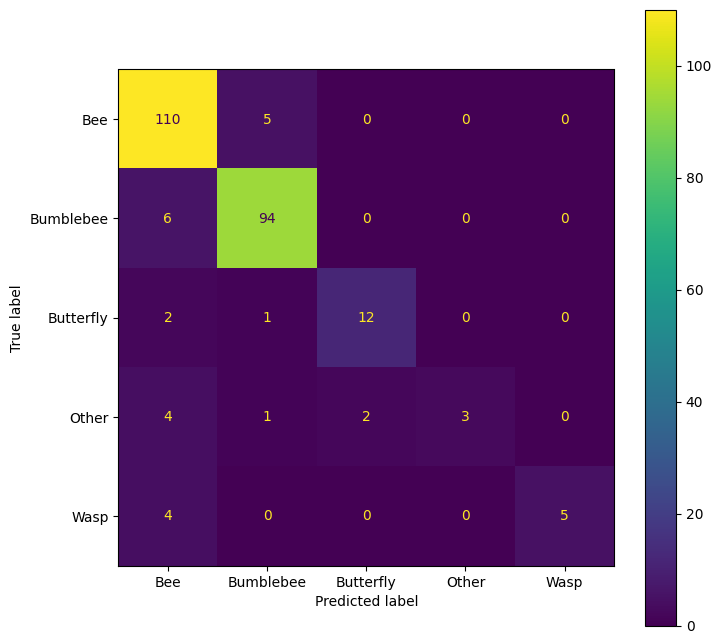

In [30]:

evaluate_classifier(models['xgb'], X_train, y_train5, plot=False, debug=False, n_jobs=-1, cv=cv)
#evaluate_classifier(models['lgb'], X_train, y_train5, plot=False, debug=False, n_jobs=-1, cv=cv)
#evaluate_classifier(models['rf'], X_train, y_train5, plot=False, debug=False, n_jobs=-1, cv=cv)


In [31]:
# With dynamic weights
weights = set_dynamic_weights(models, X_train, y_train5, method='exponential', base=6, min_acceptable_score=0.85)

et model: 0.8512 (weight: 1.0000)
knn model: 0.8554 (weight: 1.1666)
lda model: 0.8914 (weight: 4.4405)
lgb model: 0.8715 (weight: 2.1198)
log model: 0.8955 (weight: 5.1556)
poly_svc model: 0.8957 (weight: 5.1923)
rbf_svc model: 0.8956 (weight: 5.1801)
rf model: 0.8674 (weight: 1.8258)
sigmoid_svc model: 0.8835 (weight: 3.3098)
xgb model: 0.8996 (weight: 6.0000)


[0 1 2 3 4]
Accuracy: 0.9116465863453815
Precision: 0.914746900574781
Recall: 0.9116465863453815
F1 Score: 0.9049583344216389
              precision    recall  f1-score   support

         Bee       0.89      0.96      0.92       115
   Bumblebee       0.93      0.94      0.94       100
   Butterfly       0.86      0.80      0.83        15
       Other       1.00      0.30      0.46        10
        Wasp       1.00      0.89      0.94         9

    accuracy                           0.91       249
   macro avg       0.94      0.78      0.82       249
weighted avg       0.91      0.91      0.90       249



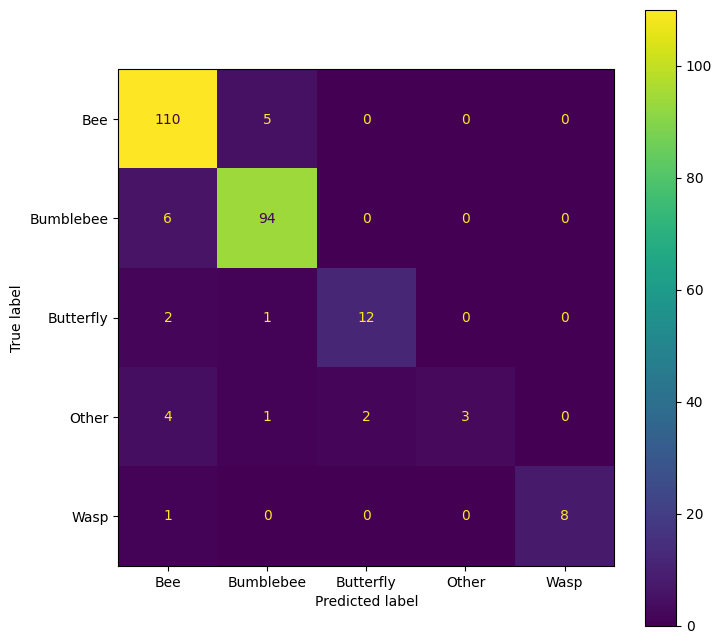

In [32]:
voting_clf = VotingClassifier(
    estimators=models_tuples,
    voting='hard',  # Change to 'soft' for using probabilities
    weights=weights
)
voting_pipe = imbPipeline([
    ('model', voting_clf)
])
evaluate_classifier(voting_pipe, X_train, y_train5)

## B - Prediction on test set

We can now estimate the bug type of the test set using our model

In [33]:
voting_pipe.fit(X_train, y_encoded_train5)
y_encoded_pred5 = voting_pipe.predict(X_test)
y_pred5 = labelencoder.inverse_transform(y_encoded_pred5)
y_pred5[:5]
# show how sure hte model is thanks to predict_proba
#y_pred_proba5 = voting_pipe.predict_proba(X_test)
#y_pred_proba5[:5]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 51
[LightGBM] [Info] Start training from score -0.935240
[LightGBM] [Info] Start training from score -1.075002
[LightGBM] [Info] Start training from score -2.246185
[LightGBM] [Info] Start training from score -2.635650
[LightGBM] [Info] Start training from score -2.422076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


array(['Bee', 'Bee', 'Bee', 'Bee', 'Bumblebee'], dtype=object)

In [34]:
voting_clf.fit(X_train, y_encoded_train5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 51
[LightGBM] [Info] Start training from score -0.935240
[LightGBM] [Info] Start training from score -1.075002
[LightGBM] [Info] Start training from score -2.246185
[LightGBM] [Info] Start training from score -2.635650
[LightGBM] [Info] Start training from score -2.422076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


VotingClassifier(estimators=[('et',
                              Pipeline(steps=[('dim_reductor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('pca',
                                                                                PCA(n_components=0.8),
                                                                                [1,
                                                                                 2,
                                                                                 10,
                                                                                 11,
                                                                                 16,
                                                                                 18,
                                                                                 20,
                                                                                 21,
                                                                                 22,
                                                                                 23,
                                                                                 24,
                                                                                 25,
                                                                                 26,
                                                                                 27,
                                                                                 28,
                                                                                 29,
                                                                                 30,
                                                                                 31,
                                                                                 32,
                                                                                 33,
                                                                                 35,
                                                                                 37,
                                                                                 38,
                                                                                 39,
                                                                                 42,
                                                                                 43,
                                                                                 44,
                                                                                 46,
                                                                                 47,
                                                                                 48, ...])])),
                                              ('scaler', StandardScaler()),
                                              ('adasyn',
                                               ADASYN(n_jobs=-1, n_neighbors=4,
                                                      random_state=10,
                                                      sampling_strate...
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=2,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=337,
                                                             n_jobs=None,
                                                             num_parallel_tr

- To have a rough - but very approximate and inexact - estimate of the performance to expect, we computed
confidence scores based on the predictions of each of the voting classifier’s estimators :
the ratio of the weighted number of votes for the predicted class by the total weights.

- Ideally, we should have used existing methods to predict the probability, supported for
instance by x. However, not all models that we combined supported this well since the
method from the Support Vector Classifier of sklearn is reportedly meaningless on small
datasets, inconsistent with the method for prediction, and requires extra computation. So,
to visualize our confidence scores, we made a histogram of its distribution colored by the
bug type.

In [35]:

from scipy.stats import mode
def calculate_weighted_confidence(voting_clf, X):
    # Extract pipelines and weights from the VotingClassifier
    pipelines = [est for est in voting_clf.estimators_]
    weights = voting_clf.weights if voting_clf.weights is not None else [1] * len(pipelines)
    
    # Get predictions from each individual estimator pipeline
    individual_preds = np.array([pipe.predict(X) for pipe in pipelines])
    
    # Calculate the majority vote predictions across all estimators
    # Assuming `voting='hard'`, this will be the modal (most common) prediction per sample
    y_pred, _ = mode(individual_preds, axis=0)
    y_pred = y_pred.ravel()  # Flatten the array to 1D

    # Count votes for the winning class for each sample, considering weights
    confidence_scores = np.zeros(len(X))
    
    for i in range(len(X)):
        # Get the most voted class for the current sample
        most_voted_class = y_pred[i]
        
        # Count weighted votes for the most voted class
        votes_for_most_voted = sum(weight for pipe, weight, pred in zip(pipelines, weights, individual_preds[:, i]) if pred == most_voted_class)
        
        # Calculate the ratio of votes for the most voted class
        confidence_scores[i] = votes_for_most_voted / sum(weights)
    
    return confidence_scores

# After fitting your voting_clf on training data
confidence_scores = calculate_weighted_confidence(voting_clf, X_test)

# Optionally, you can view or use these confidence scores
print(confidence_scores[:5])


[0.78100648 1.         1.         1.         0.46771466]


In [36]:
len(confidence_scores), len(y_pred5)

(97, 97)

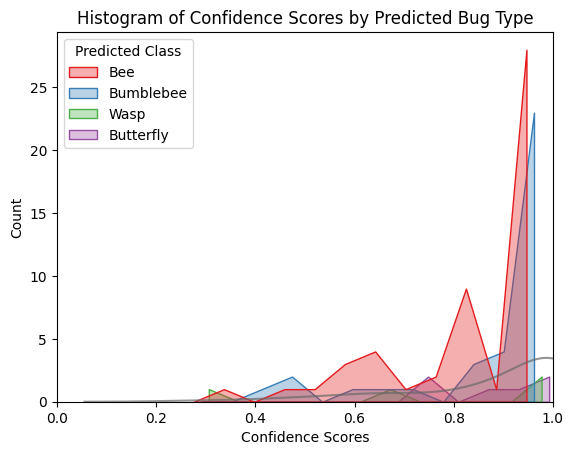

In [38]:
data = pd.DataFrame({'Confidence Scores': confidence_scores, 'Predicted Class': y_pred5})

# Set the color palette based on the predicted class
palette = sns.color_palette('Set1', n_colors=len(data['Predicted Class'].unique()))

# Plot the histogram  with bigger edges for poly element
ax = sns.kdeplot(confidence_scores, color='dimgrey', alpha=0.7)
ax = sns.histplot(data=data, x='Confidence Scores', hue='Predicted Class', palette=palette, multiple='dodge', element='poly', alpha=0.35,stat='count')
# set limits between 0 and 1
ax.set_xlim(0, 1)
sns.move_legend(ax, "upper left")

# Set plot title and labels
plt.title('Histogram of Confidence Scores by Predicted Bug Type')
plt.xlabel('Confidence Scores')
plt.ylabel('Count')

# Show the plot
plt.show()

- The plot allows us to see that most estimators often vote for the same class. Despite
the fact that the learning process is different for most of our algorithms, they often find the
same label, which may be an indicator of a good learning process but doesn’t necessarily
mean that the accuracy is going to be extremely high. 

- Interestingly, our models generally agree when predicting a butterfly, while they are much more split on the wasps. 

- Also, our models didn’t predict a single bug type ‘Other’, which regrouped Dragonfly and Hoverfly,
which is definitely not ideal as there are likely a few of them. But given that this class
proved very hard to predict during our training and evaluation process and had a very low
number of samples, we think that this is not a major issue. Properly learning from a single
dragonfly wasn’t possible anyways, and combining it with hover flies which are still quite
different made the identification of that group even harder, so our options were limited.

In [42]:
# save predictions as dataframe with the same index as the test data and the predicted bug type
submission = pd.DataFrame({'bug_type': y_pred5}, index=X_test.index)
submission

,bug_type
ID,
251,Bee
252,Bee
253,Bee
254,Bee
255,Bumblebee
256,Bumblebee
257,Bee
258,Bee
259,Bee


In [53]:
submission.to_csv('data/prediction.csv')